In [1]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM, GRU
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [3]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [4]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [5]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [6]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.85 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

## model - order=(1, 0, 3), seasonal_order=(1, 0, 2, 52) 
- p/d/q order extracted from the best parameters from the SARIMAX notebook.
- The parameters are the same as the baseline model (Best accuracy metrics across 4 different seasonalities).

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 52)   Log Likelihood                2537.512
Date:                                 Sat, 30 Nov 2024   AIC                          -5049.025
Time:                                         13:37:42   BIC                          -4986.945
Sample:                                     04-01-2004   HQIC                         -5025.279
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4156      0.097     14.645      0.000  

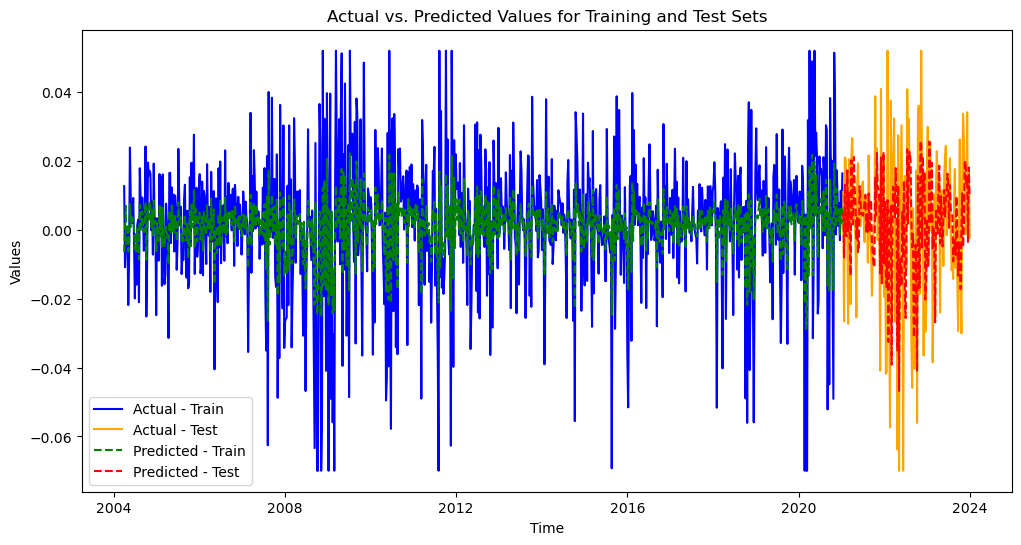

In [8]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_52 = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_52.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_52.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_52.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

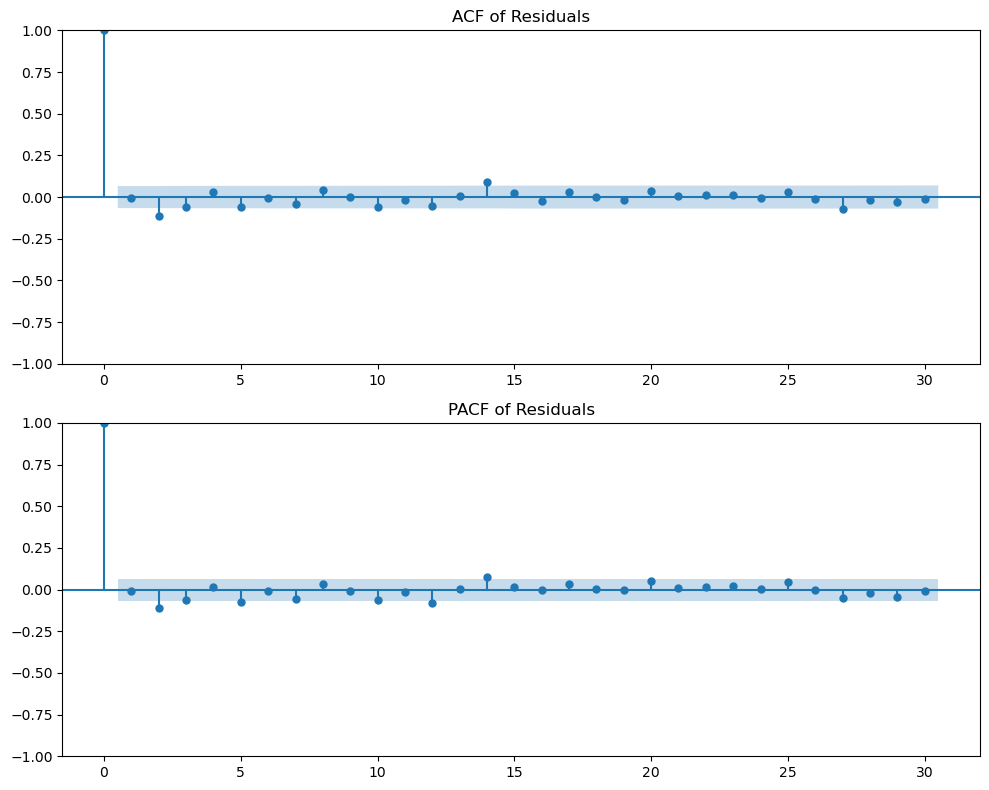

In [9]:
# Calculate residuals from the fitted model.
residuals_52 = sarimax_final_52.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals_52, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals_52, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

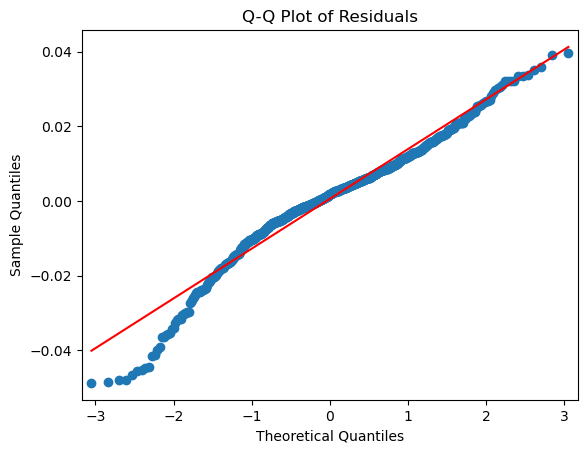

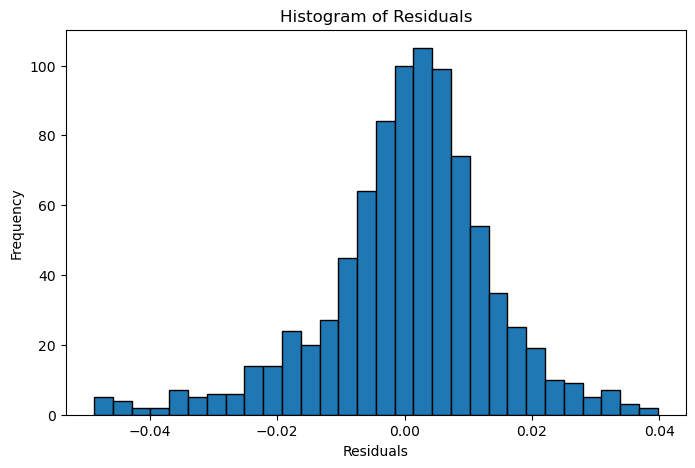

In [10]:
# Q-Q plot for normality check.
sm.qqplot(residuals_52, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals_52, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals_52, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals_52)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results

      lb_stat  lb_pvalue
10  24.333845   0.006762
20  37.871745   0.009181
30  44.706827   0.041094
ARCH Test p-value: 7.96929136614076e-24


In [12]:
residuals_52.describe()

count    876.000000
mean       0.000569
std        0.013350
min       -0.048768
25%       -0.005453
50%        0.001800
75%        0.008253
max        0.039730
dtype: float64

PREPING THE RESIDUALS

In [14]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(residuals_52))
y_train = residuals_52[:train_size]
y_test = residuals_52[train_size:]

scaler = RobustScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Scale test residuals using the same scaler
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Residuals - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Residuals - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Residuals - Min: -3.85869056677459 Max: 2.9805438200086716
Scaled Test Residuals - Min: -3.8372178777583628 Max: 2.491930846040733


## Sequence Length = 4

In [16]:
# Reshape residual data into sequences for LSTM.
sequence_length = 4  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")   

Reshaped X_train_seq shape: (740, 4, 1)
Reshaped y_train_seq shape: (740, 1)
Reshaped X_test_seq shape: (128, 4, 1)
Reshaped y_test_seq shape: (128, 1)


### Random Search with Optuna

In [18]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-30 13:37:44,352] A new study created in memory with name: no-name-bf2e3f57-79e9-4948-a3bb-1e2ab87d9dec
[I 2024-11-30 13:38:03,230] Trial 0 finished with value: 1.8805947303771973 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.8805947303771973.
[I 2024-11-30 13:38:20,807] Trial 1 finished with value: 3.68806791305542 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.8805947303771973.
[I 2024-11-30 13:39:02,296] Trial 2 finished with value: 3.46097469329834 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.002556815375065554, 'learning_rate': 0.0005, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 100, 'batch_size': 120}
Best validation loss: 0.8619473576545715


In [19]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001047148538910998,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.3218 - val_loss: 0.8649
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2909 - val_loss: 0.8705
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3515 - val_loss: 0.8711
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2249 - val_loss: 0.8731
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2318 - val_loss: 0.8744
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1884 - val_loss: 0.8719
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1236 - val_loss: 0.8709
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1064 - val_loss: 0.8699
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1259 - val_loss: 0.8694
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2073 - val_loss: 0.8692
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1337 - val_loss: 0.8698
Final Training Loss: 1.1443883180618286
Final Validation Loss: 0.8698012232780457


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
LSTM Model Performance:
Training RMSE: 0.012877285708452214
Test RMSE: 0.015759867503248825
Training MAE: 0.009336506767163666
Test MAE: 0.011901415700068033
Directional Accuracy on Training Data: 72.66576454668471%
Directional Accuracy on Test Data: 70.07874015748031%


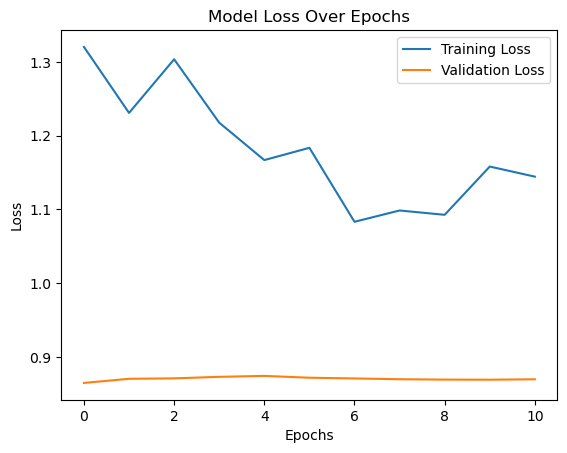

In [20]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [22]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 10s]
val_loss: 1.5195515155792236

Best val_loss So Far: 1.4722371101379395
Total elapsed time: 00h 14m 58s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.004687701723470747, learning_rate=0.0001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.004687701723470747, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [23]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.0012552296387001707,
    'epochs': 120,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 1.3716 - val_loss: 0.8582
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3134 - val_loss: 0.8589
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4403 - val_loss: 0.8595
Epoch 4/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2891 - val_loss: 0.8602
Epoch 5/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3150 - val_loss: 0.8610
Epoch 6/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3244 - val_loss: 0.8613
Epoch 7/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2568 - val_loss: 0.8618
Epoch 8/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2312 - val_loss: 0.8622
Epoch 9/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2329 - val_loss: 0.8623
Epoch 10/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3719 - val_loss: 0.8625
Epoch 11/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3058 - val_loss: 0.8627
Final Training Loss: 1.3091295957565308
Final Validation Loss: 0.862657725

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.012916995393156688
Test RMSE: 0.0157660955235453
Training MAE: 0.009345300092662318
Test MAE: 0.011840937424754071
Directional Accuracy on Training Data: 35.72395128552097%
Directional Accuracy on Test Data: 37.00787401574803%


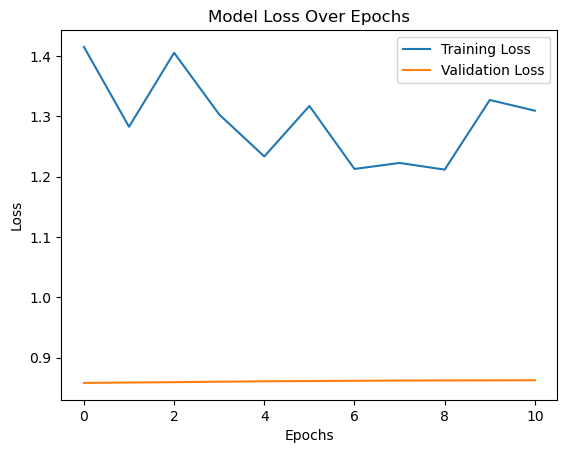

In [24]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [26]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.386767864227295
Final Validation Loss: 1.8105177879333496
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.795293927192688
Final Validation Loss: 2.016911268234253
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.3150473833084106
Final Validation Loss: 1.6561436653137207
Running combination 4/3

In [27]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 2.9783 - val_loss: 1.5593
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2981 - val_loss: 1.5522
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0542 - val_loss: 1.5528
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9259 - val_loss: 1.5489
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8469 - val_loss: 1.5571
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6438 - val_loss: 1.5544
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6408 - val_loss: 1.5602
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5604 - val_loss: 1.5639
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4644 - val_loss: 1.5610
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5116 - val_loss: 1.5710
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3842 - val_loss: 1.5646
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.012888624004500205
Test RMSE: 0.01578619018899724
Training MAE: 0.009362491628291126
Test MAE: 0.011981878947139774
Directional Accuracy on Training Data: 54.26251691474966%
Directional Accuracy on Test Data: 56.69291338582677%


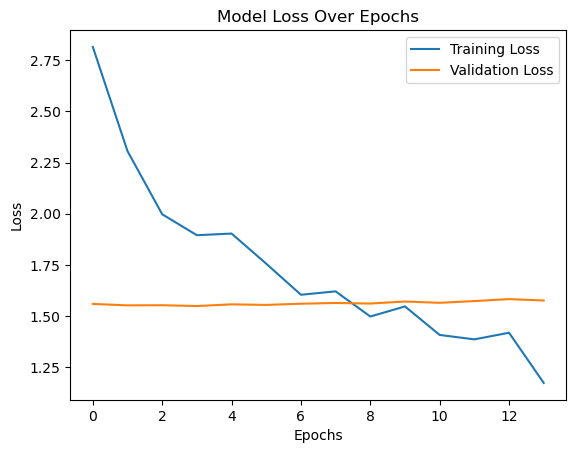

In [28]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [30]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.997239351272583
Final Validation Loss: 1.9490796327590942
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.125816822052002
Final Validation Loss: 4.106977462768555
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.801438093185425
Final Validati

In [31]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 2.8850 - val_loss: 1.0405
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.4657 - val_loss: 1.0475
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1618 - val_loss: 1.0518
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9825 - val_loss: 1.0556
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8622 - val_loss: 1.0523
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.8197 - val_loss: 1.0467
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6687 - val_loss: 1.0397
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.8614 - val_loss: 1.0389
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8267 - val_loss: 1.0427
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5916 - val_loss: 1.0456
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.6761 - val_loss: 1.0443
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.5723 - val_

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.012892697493334257
Test RMSE: 0.015748315542329458
Training MAE: 0.00934177023761552
Test MAE: 0.011881953435222973
Directional Accuracy on Training Data: 50.608930987821374%
Directional Accuracy on Test Data: 51.181102362204726%


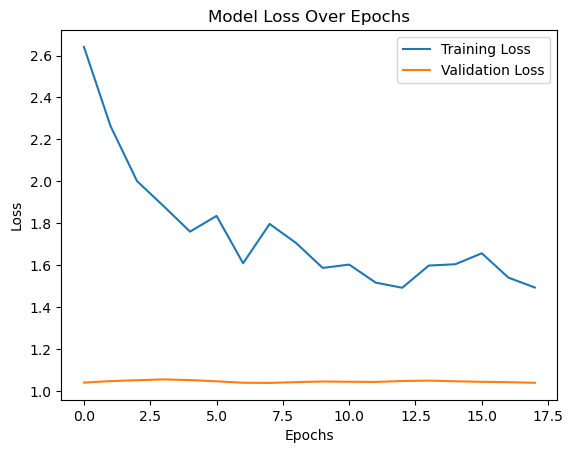

In [32]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation of the best model with SL of 4 with Descaled Metrics.

In [ ]:
# Best model sequence length = 4
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.0012552296387001707,
    'epochs': 120,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model
# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the initial model weights to reset after each fold
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

In [ ]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

In [ ]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

In [ ]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

## Sequence Length = 12

In [35]:
# Reshape residual data into sequences for LSTM.
sequence_length = 12  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (732, 12, 1)
Reshaped y_train_seq shape: (732, 1)
Reshaped X_test_seq shape: (120, 12, 1)
Reshaped y_test_seq shape: (120, 1)


### Random Search with Optuna

In [37]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-30 14:23:11,382] A new study created in memory with name: no-name-8da017ec-4fec-4868-bc9f-3f6decc15235
[I 2024-11-30 14:23:32,374] Trial 0 finished with value: 1.9950776100158691 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.9950776100158691.
[I 2024-11-30 14:23:55,991] Trial 1 finished with value: 3.784799098968506 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.9950776100158691.
[I 2024-11-30 14:25:04,910] Trial 2 finished with value: 4.341187000274658 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.028980866560207673, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 1.0, 'units': 64, 'num_layers': 1, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.5393531322479248


In [38]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.028980866560207673,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 1.3697 - val_loss: 1.6200
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3533 - val_loss: 1.6176
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4313 - val_loss: 1.6163
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3157 - val_loss: 1.6162
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3030 - val_loss: 1.6153
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2942 - val_loss: 1.6133
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2301 - val_loss: 1.6106
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2820 - val_loss: 1.6099
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2915 - val_loss: 1.6070
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2588 - val_loss: 1.6038
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1840 - val_loss: 1.6026
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2199 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.013051281485430968
Test RMSE: 0.01608515344026832
Training MAE: 0.009321658925029199
Test MAE: 0.011728616882820673
Directional Accuracy on Training Data: 68.2626538987688%
Directional Accuracy on Test Data: 74.78991596638656%


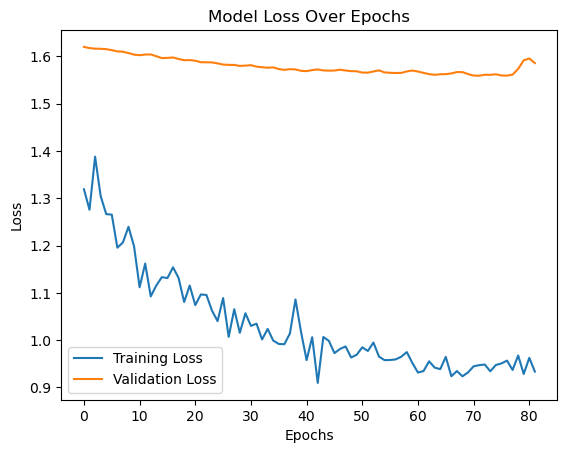

In [39]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [41]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 15s]
val_loss: 1.5365333557128906

Best val_loss So Far: 1.5308971405029297
Total elapsed time: 00h 22m 53s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.004687701723470747, learning_rate=0.0001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.004687701723470747, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [42]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.005777535037556758,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - loss: 1.3432 - val_loss: 1.5735
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.2654 - val_loss: 1.5779
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.2209 - val_loss: 1.5727
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.2815 - val_loss: 1.5755
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.3055 - val_loss: 1.5778
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.2089 - val_loss: 1.5737
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.2500 - val_loss: 1.5739
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.1838 - val_loss: 1.5739
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1418 - val_loss: 1.5730
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.1127 - val_loss: 1.5720
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.1413 - val_loss: 1.5711
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.2213 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.012913811563017871
Test RMSE: 0.01613990881827147
Training MAE: 0.00933996890897813
Test MAE: 0.012160301982050115
Directional Accuracy on Training Data: 68.94664842681259%
Directional Accuracy on Test Data: 73.94957983193278%


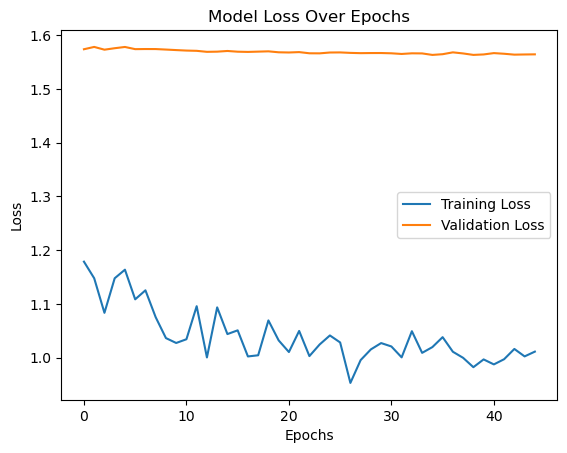

In [43]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [45]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.4051742553710938
Final Validation Loss: 1.9073702096939087
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.7273719310760498
Final Validation Loss: 2.060608148574829
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.2654861211776733
Final Validation Loss: 1.765685796737671
Running combination 4/

In [46]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - loss: 4.5757 - val_loss: 1.6246
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.7161 - val_loss: 1.6239
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.6215 - val_loss: 1.6230
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.3014 - val_loss: 1.6250
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.2849 - val_loss: 1.6248
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.1176 - val_loss: 1.6234
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.0421 - val_loss: 1.6244
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.1927 - val_loss: 1.6277
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.9094 - val_loss: 1.6291
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.8488 - val_loss: 1.6289
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.8027 - val_loss: 1.6300
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.0373 - val_

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.012925642554959501
Test RMSE: 0.016185110978653317
Training MAE: 0.009381702540091658
Test MAE: 0.012319632484586281
Directional Accuracy on Training Data: 64.15868673050615%
Directional Accuracy on Test Data: 65.54621848739495%


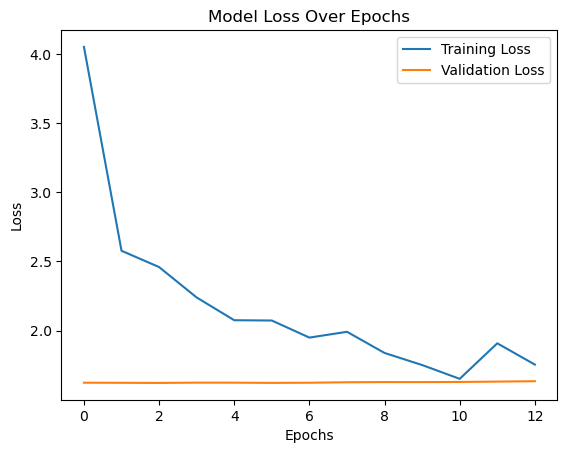

In [47]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [49]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0723460912704468
Final Validation Loss: 1.88726806640625
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.050075054168701
Final Validation Loss: 4.248191833496094
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.7130210399627686
Final Validati

In [50]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 3.5304 - val_loss: 1.6848
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7145 - val_loss: 1.6861
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.4070 - val_loss: 1.6877
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1517 - val_loss: 1.6877
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.3384 - val_loss: 1.6893
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.8554 - val_loss: 1.6898
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.1644 - val_loss: 1.6879
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9666 - val_loss: 1.6914
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9816 - val_loss: 1.6899
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.1886 - val_loss: 1.6752
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.0630 - val_loss: 1.6697
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/ste

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.01314466429986529
Test RMSE: 0.015900867684278754
Training MAE: 0.009585862607275663
Test MAE: 0.012151711066995856
Directional Accuracy on Training Data: 56.49794801641587%
Directional Accuracy on Test Data: 59.66386554621849%


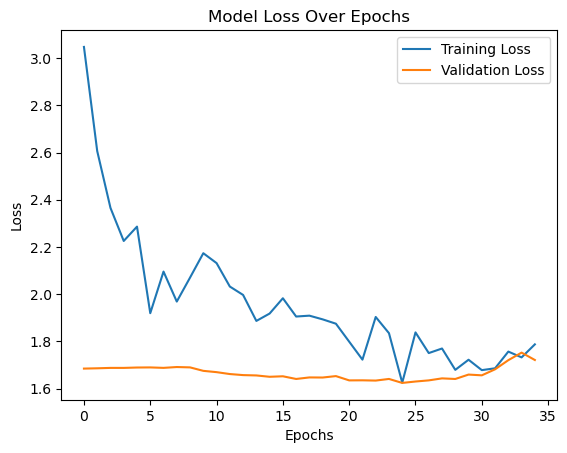

In [51]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Sequence Length = 26

In [54]:
# Reshape residual data into sequences for LSTM.
sequence_length = 26  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (718, 26, 1)
Reshaped y_train_seq shape: (718, 1)
Reshaped X_test_seq shape: (106, 26, 1)
Reshaped y_test_seq shape: (106, 1)


### Random Search with Optuna

In [56]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-30 15:19:50,435] A new study created in memory with name: no-name-7746220e-8935-4f7b-a6f7-72f41817ffc3
[I 2024-11-30 15:20:13,220] Trial 0 finished with value: 1.8583238124847412 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.8583238124847412.
[I 2024-11-30 15:20:40,361] Trial 1 finished with value: 3.6381354331970215 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.8583238124847412.
[I 2024-11-30 15:22:31,164] Trial 2 finished with value: 4.32663631439209 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0012275249423367388, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 200, 'batch_size': 32}
Best validation loss: 1.1327369213104248


In [57]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.002484158683943087,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 1.0524 - val_loss: 1.2550
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0620 - val_loss: 1.2683
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0608 - val_loss: 1.2586
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0600 - val_loss: 1.2589
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9916 - val_loss: 1.2558
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9940 - val_loss: 1.2603
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0236 - val_loss: 1.2478
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9932 - val_loss: 1.2451
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0513 - val_loss: 1.2452
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9840 - val_loss: 1.2389
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0126 - val_loss: 1.2385
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.012937164025423078
Test RMSE: 0.01509790455852947
Training MAE: 0.009407245638895693
Test MAE: 0.01132653223021531
Directional Accuracy on Training Data: 72.38493723849372%
Directional Accuracy on Test Data: 72.38095238095238%


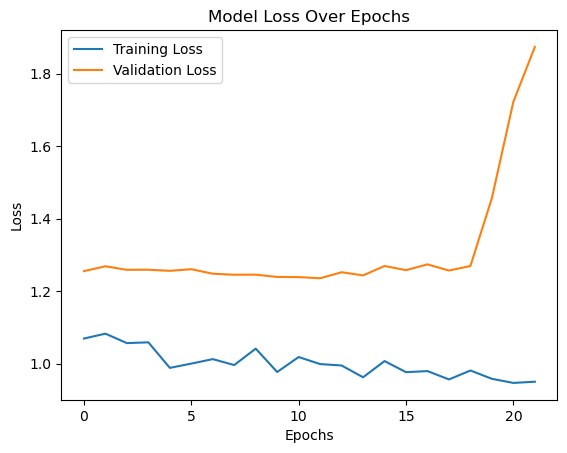

In [58]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [60]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 12s]
val_loss: 1.2448205947875977

Best val_loss So Far: 1.1329412460327148
Total elapsed time: 00h 29m 38s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.2, l2_lambda=0.0012082800116555404, learning_rate=0.0001, learning_rate_decay=0.0, clipnorm=1.0, units=64, num_layers=1, batch_size=32
Best hyperparameters for LSTM: {'dropout_rate': 0.3, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0012082800116555404, 'learning_rate': 0.0001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 64, 'num_layers': 1, 'batch_size': 32}
Best batch size for LSTM: 32


In [61]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.07175729983533158,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 2.3379 - val_loss: 1.5419
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.1239 - val_loss: 1.5392
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.9105 - val_loss: 1.5371
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.6654 - val_loss: 1.5364
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5220 - val_loss: 1.5358
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5564 - val_loss: 1.5351
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.6248 - val_loss: 1.5335
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.4153 - val_loss: 1.5309
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5452 - val_loss: 1.5281
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.4925 - val_loss: 1.5248
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5893 - val_loss: 1.5205
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.4560 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.012997696136237448
Test RMSE: 0.015422038438463532
Training MAE: 0.00950031868170662
Test MAE: 0.011766682450533633
Directional Accuracy on Training Data: 73.08228730822873%
Directional Accuracy on Test Data: 73.33333333333333%


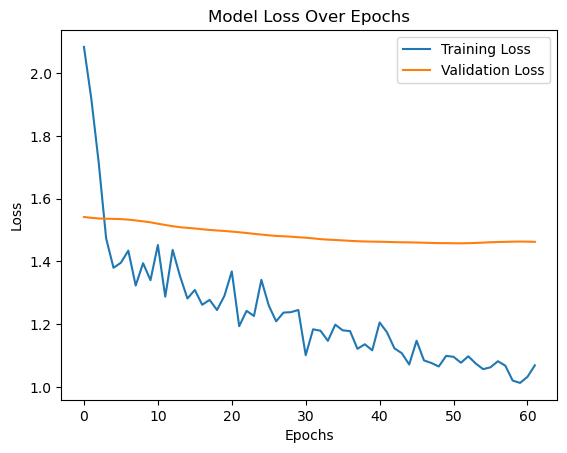

In [62]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [64]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.458718180656433
Final Validation Loss: 1.792324423789978
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.0201828479766846
Final Validation Loss: 2.0290255546569824
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.568984031677246
Final Validation Loss: 1.6607844829559326
Running combination 4/3

In [65]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 2.8313 - val_loss: 1.3434
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.2852 - val_loss: 1.3459
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9696 - val_loss: 1.3459
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.8402 - val_loss: 1.3349
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.7976 - val_loss: 1.3393
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6960 - val_loss: 1.3244
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.5586 - val_loss: 1.3347
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4021 - val_loss: 1.3314
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.3974 - val_loss: 1.3518
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.4368 - val_loss: 1.3104
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.4168 - val_loss: 1.3113
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/ste

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM Model Performance:
Training RMSE: 0.013335863943072223
Test RMSE: 0.015000911925208539
Training MAE: 0.009746481364635736
Test MAE: 0.011378628520461904
Directional Accuracy on Training Data: 54.39330543933054%
Directional Accuracy on Test Data: 65.71428571428571%


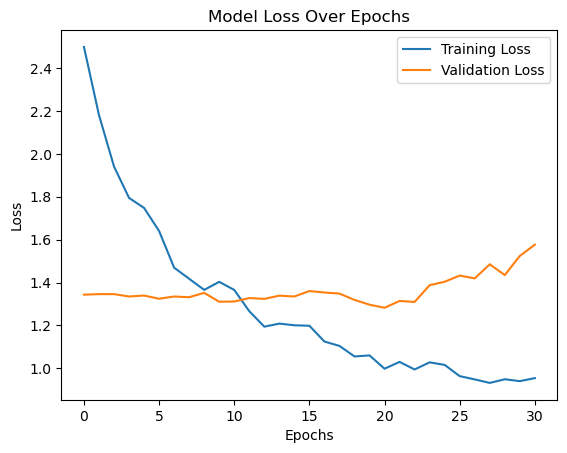

In [66]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [68]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.162468671798706
Final Validation Loss: 1.6468729972839355
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.045502185821533
Final Validation Loss: 3.963886260986328
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.621056079864502
Final Validati

In [69]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 489ms/step - loss: 4.4290 - val_loss: 1.5689
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 4.0471 - val_loss: 1.5705
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 3.7476 - val_loss: 1.5733
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 3.3993 - val_loss: 1.5780
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 3.2017 - val_loss: 1.5806
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 3.1246 - val_loss: 1.5802
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 2.9592 - val_loss: 1.5772
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 2.9231 - val_loss: 1.5775
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 2.9791 - val_loss: 1.5778
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 2.7405 - val_loss: 1.5784
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 2.8631 - val_loss: 1.5778
Final Training Loss: 2.7360801696777344
Final Validation Loss:

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM Model Performance:
Training RMSE: 0.013038139984653302
Test RMSE: 0.015250019241195279
Training MAE: 0.009434241324893403
Test MAE: 0.011313049531722899
Directional Accuracy on Training Data: 47.977684797768475%
Directional Accuracy on Test Data: 49.523809523809526%


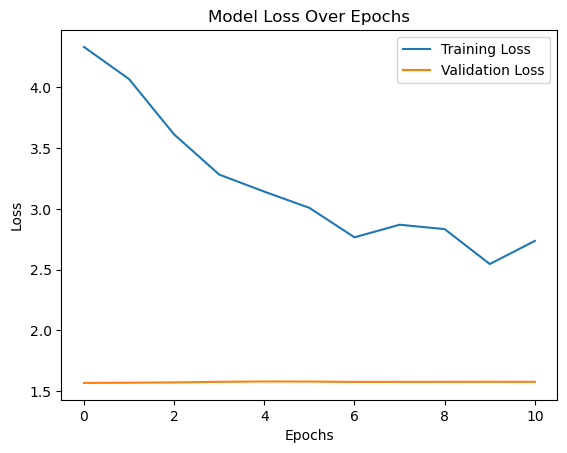

In [70]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
print(f"train_predictions shape: {train_predictions.shape}")
print(f"y_train_pred_rescaled shape: {y_train_pred_rescaled.shape}")


train_predictions shape: (876,)
y_train_pred_rescaled shape: (718, 1)


In [72]:
# Align SARIMAX predictions with LSTM residual predictions
aligned_train_predictions = train_predictions[-len(y_train_pred_rescaled):]
aligned_test_predictions = test_predictions[-len(y_test_pred_rescaled):]

# Combine SARIMAX and LSTM predictions for the training and test sets
hybrid_train_predictions = aligned_train_predictions + y_train_pred_rescaled.flatten()
hybrid_test_predictions = aligned_test_predictions + y_test_pred_rescaled.flatten()

# Confirm the alignment
print(f"Aligned train_predictions shape: {aligned_train_predictions.shape}")
print(f"hybrid_train_predictions shape: {hybrid_train_predictions.shape}")

Aligned train_predictions shape: (718,)
hybrid_train_predictions shape: (718,)


In [73]:
# Calculate RMSE for the hybrid model
hybrid_train_rmse = np.sqrt(mean_squared_error(train[-len(hybrid_train_predictions):], hybrid_train_predictions))
hybrid_test_rmse = np.sqrt(mean_squared_error(test[-len(hybrid_test_predictions):], hybrid_test_predictions))

# Calculate MAE for the hybrid model
hybrid_train_mae = mean_absolute_error(train[-len(hybrid_train_predictions):], hybrid_train_predictions)
hybrid_test_mae = mean_absolute_error(test[-len(hybrid_test_predictions):], hybrid_test_predictions)

# Calculate Directional Accuracy for the hybrid model
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

hybrid_train_directional_accuracy = directional_accuracy(train[-len(hybrid_train_predictions):].values, hybrid_train_predictions)
hybrid_test_directional_accuracy = directional_accuracy(test[-len(hybrid_test_predictions):].values, hybrid_test_predictions)

# Display Metrics
print("Hybrid Model Performance:")
print(f"Training RMSE: {hybrid_train_rmse}")
print(f"Test RMSE: {hybrid_test_rmse}")
print(f"Training MAE: {hybrid_train_mae}")
print(f"Test MAE: {hybrid_test_mae}")
print(f"Directional Accuracy on Training Data: {hybrid_train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {hybrid_test_directional_accuracy}%")

ValueError: ('Lengths must match to compare', (718,), (717,))

In [ ]:
# Plot actual vs. hybrid predictions for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train[-len(hybrid_train_predictions):].index, train[-len(hybrid_train_predictions):], label="Actual - Train", color='blue')
plt.plot(test[-len(hybrid_test_predictions):].index, test[-len(hybrid_test_predictions):], label="Actual - Test", color='orange')

# Plot hybrid predictions
plt.plot(train[-len(hybrid_train_predictions):].index, hybrid_train_predictions, label="Hybrid Prediction - Train", linestyle='--', color='green')
plt.plot(test[-len(hybrid_test_predictions):].index, hybrid_test_predictions, label="Hybrid Prediction - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Hybrid Predictions for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()


In [ ]:
# Calculate residuals for the hybrid model
hybrid_train_residuals = train[-len(hybrid_train_predictions):] - hybrid_train_predictions
hybrid_test_residuals = test[-len(hybrid_test_predictions):] - hybrid_test_predictions

# Plot residuals for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train[-len(hybrid_train_predictions):].index, hybrid_train_residuals, label="Residuals - Train", color='blue')
plt.plot(test[-len(hybrid_test_predictions):].index, hybrid_test_residuals, label="Residuals - Test", color='orange')

plt.legend()
plt.title("Hybrid Model Residuals for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()


## Sequence Length = 52

In [ ]:
# Reshape residual data into sequences for LSTM.
sequence_length = 52  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")  

### Random Search with Optuna

In [ ]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

In [ ]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.005593134253013597,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

In [ ]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [ ]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

In [ ]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.002638473543668802,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

In [ ]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [ ]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

In [ ]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

In [ ]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [ ]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

In [ ]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

In [ ]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation 